In [182]:
import os
import sys
import torch
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [170]:
sys.path.append(os.path.join(os.path.abspath('..'),'scripts/nn'))
from kernel_model import (VerticalKernelLayer,GaussianVerticalKernelLayer,KernelNNModel)

In [208]:
scalarvar  = 'sdo' # 3D input variable (time, lat, lon)
profilevar = 'rh'  # 4D input variable (time, lat, lon, lev)
targetvar  = 'pr'  # 3D target variable (time, lat, lon)

ds = xr.open_dataset('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/data/splits/normtrain.h5',engine='h5netcdf')
ds = ds[[scalarvar,profilevar,targetvar]]
ds = ds.isel(time=slice(0,10),lat=slice(0,10),lon=slice(0,10))

In [209]:
def reshape(da):
    if 'lev' in da.dims:
        da  = da.sortby('lev',ascending=False)
        arr = da.transpose('time','lat','lon','lev').values.reshape(-1,da.lev.size)
    else:
        arr = da.transpose('time','lat','lon').values.reshape(-1,1)
    return arr

X3D     = reshape(ds[scalarvar])
X4D     = reshape(ds[profilevar])
y       = reshape(ds[targetvar])
levels  = ds.lev.values
nlevels = levels.size

print('Shapes:')
print('- y:      ',y.shape)
print('- X3D:    ',X3D.shape)
print('- X4D:    ',X4D.shape)
print('- nlevels:',nlevels)

Shapes:
- y:       (1000, 1)
- X3D:     (1000, 1)
- X4D:     (1000, 16)
- nlevels: 16


In [210]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X3D = torch.tensor(X3D,dtype=torch.float32).to(device)
X4D = torch.tensor(X4D,dtype=torch.float32).to(device)
X = torch.cat([X3D,X4D],dim=1)  
y = torch.tensor(y,dtype=torch.float32).to(device)

In [211]:
vkernel = VerticalKernelLayer(nlevels).to(device)
gkernel = GaussianVerticalKernelLayer(levels).to(device)

vout = vkernel(X4D)
gout = gkernel(X4D)  

print('Vertical kernel output shape (expect nsamples, 1):',vout.shape)
print('Gaussian kernel output shape (expect nsamples, 1):',gout.shape)

Vertical kernel output shape (expect nsamples, 1): torch.Size([1000, 1])
Gaussian kernel output shape (expect nsamples, 1): torch.Size([1000, 1])


In [212]:
def get_vertical_weights(module):
    raw  = module.weights.detach()
    norm = torch.softmax(raw,dim=0)
    return raw.cpu().numpy(),norm.cpu().numpy()

def get_gaussian_weights(module):
    normlevels = module.normlevels.detach().unsqueeze(0)
    sigma = torch.exp(module.logsigma).detach()
    raw   = torch.exp(-0.5*((normlevels-module.mu.detach())/sigma)**2)
    norm  = raw/(raw.sum(dim=1,keepdim=True)+1e-12)
    return raw.squeeze().cpu().numpy(),norm.squeeze().cpu().numpy()

untrainedvraw,untrainedvnorm = get_vertical_weights(vkernel)
untrainedgraw,untrainedgnorm = get_gaussian_weights(gkernel)
print('Vertical kernel normalization:',untrainedvnorm.sum())
print('Gaussian kernel normalization:',untrainedgnorm.sum())

Vertical kernel normalization: 1.0
Gaussian kernel normalization: 1.0


In [221]:
vmodel = KernelNNModel(nscalarfeatures=1,nlevels=nlevels,kerneltype='vertical',levels=levels).to(device)
gmodel = KernelNNModel(nscalarfeatures=1,nlevels=nlevels,kerneltype='gaussian',levels=levels).to(device)

voptimizer = torch.optim.Adam(vmodel.parameters(),lr=1e-3)
goptimizer = torch.optim.Adam(gmodel.parameters(),lr=1e-3)
criterion  = torch.nn.MSELoss()

nepochs = 8
vlosses = []
glosses = []
for epoch in range(nepochs):
    voptimizer.zero_grad()
    vypred = vmodel(X)
    vloss  = criterion(vypred,y)
    vloss.backward()
    voptimizer.step()
    vlosses.append(vloss.item())
    goptimizer.zero_grad()
    gypred = gmodel(X)
    gloss  = criterion(gypred,y)
    gloss.backward()
    goptimizer.step()
    glosses.append(gloss.item())
    print(f'Epoch {epoch+1:4d} | Vertical Loss = {vloss.item():.6f} | Gaussian Loss = {gloss.item():.6f}')

Epoch    1 | Vertical Loss = 0.197919 | Gaussian Loss = 0.314903
Epoch    2 | Vertical Loss = 0.174616 | Gaussian Loss = 0.287325
Epoch    3 | Vertical Loss = 0.151493 | Gaussian Loss = 0.259592
Epoch    4 | Vertical Loss = 0.128876 | Gaussian Loss = 0.231631
Epoch    5 | Vertical Loss = 0.104704 | Gaussian Loss = 0.199570
Epoch    6 | Vertical Loss = 0.079015 | Gaussian Loss = 0.166460
Epoch    7 | Vertical Loss = 0.055601 | Gaussian Loss = 0.131502
Epoch    8 | Vertical Loss = 0.037692 | Gaussian Loss = 0.096218


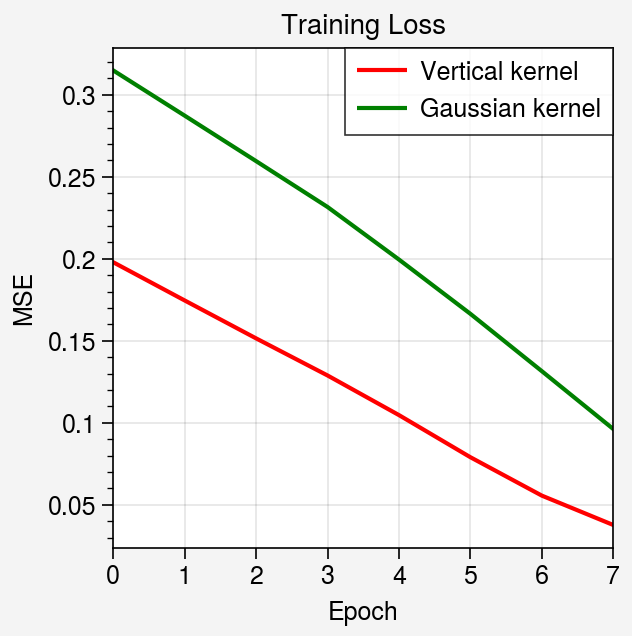

In [223]:
fig,ax = pplt.subplots(nrows=1,ncols=1)
ax.format(title='Training Loss',xlabel='Epoch',xticks=1,xminorticks='none',ylabel='MSE')
ax.plot(vlosses,color='r',label='Vertical kernel')
ax.plot(glosses,color='g',label='Gaussian kernel')
ax.legend(loc='ur',ncols=1)
pplt.show()

In [224]:
trainedvraw,trainedvnorm = get_vertical_weights(vmodel.kernel)
trainedgraw,trainedgnorm = get_gaussian_weights(gmodel.kernel)
print('Vertical kernel normalization:',trainedvnorm.sum())
print('Gaussian kernel normalization:',trainedgnorm.sum())

Vertical kernel normalization: 1.0
Gaussian kernel normalization: 1.0


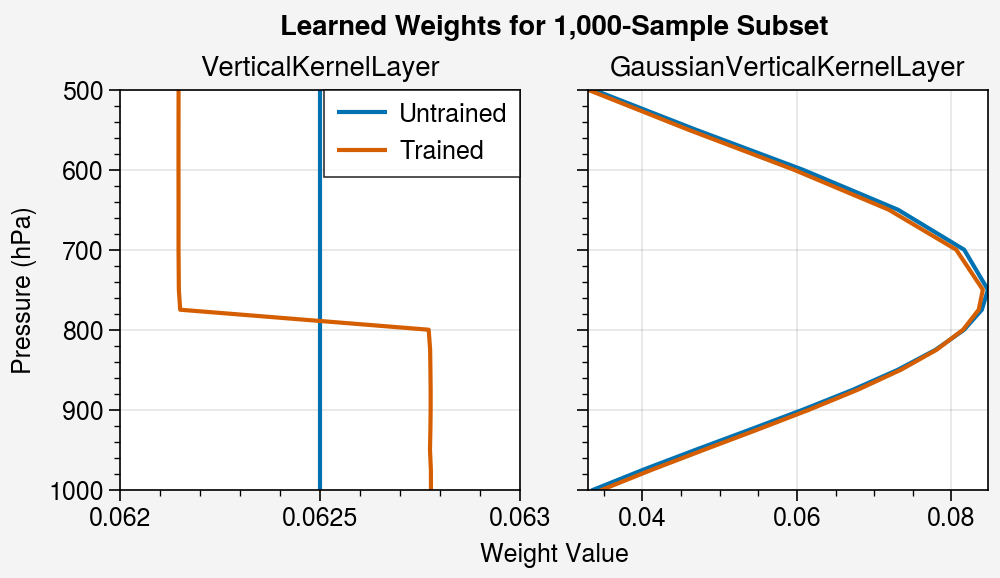

In [245]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=2,sharex=True)
axs.format(suptitle='Learned Weights for 1,000-Sample Subset',xlabel='Weight Value',ylabel='Pressure (hPa)',ylim=(levels.max(),levels.min()))
axs[0].plot(untrainedvnorm,levels,label='Untrained')
axs[0].plot(trainedvnorm,levels,label='Trained')
axs[0].format(title='VerticalKernelLayer',xlim=(0.062,0.063),xticks=0.0005)
axs[1].plot(untrainedgnorm,levels,label='Untrained')
axs[1].plot(trainedgnorm,levels,label='Trained')
axs[1].format(title='GaussianVerticalKernelLayer')
axs[0].legend(loc='ur',ncols=1)
pplt.show()

- **Vertical kernel** (non-parametric)
    - Learns one independent weight per pressure level, with no structural assumptions
    - Normalizes those weights (via softmax) so they always sum to 1
    - Can learn any shape the data "prefers"
    - The most flexible, but can overfit and be noisy
- **Gaussian kernel** (parametric)
    - Assumes the vertical weighting should be a smooth, bell-shaped curve
    - Learns only two parameters: μ (center level) and σ (spread/width)
    - Produces a normalized Gaussian curve that always sums to 1
    - More constrained and physically interpretable, but less flexible than the non-parametric kernel